In [1]:
import pandas as pd
# Load the Sentiment140 dataset as a data frame
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
# Print the first 5 rows of the data frame
print(f"\n The shape data is:{df.shape}")


 The shape data is:(1600000, 6)


In [2]:
data = df.copy()
data = data.sample(frac=1)

In [3]:
from pandas.api.types import is_numeric_dtype, is_string_dtype

for col_name in data.columns:
    if is_numeric_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna(0)
    elif is_string_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna('')
data.head()

,polarity,id,date,query,user,text
549404,0,2202636426,Tue Jun 16 22:08:29 PDT 2009,NO_QUERY,marc2503,"Tweetdeck for iPhone is kinda cool, but crashe..."
1121809,4,1974221276,Sat May 30 12:41:06 PDT 2009,NO_QUERY,WendyGYoung,I have now blogged for 3 days in a row!!! I am...
161795,0,1957398769,Fri May 29 00:22:46 PDT 2009,NO_QUERY,Susantse,"its at 3 am, im very tired but i can't sleep"
13219,0,1553144165,Sat Apr 18 13:29:23 PDT 2009,NO_QUERY,messageman3,misses lizzi and has to pack &gt;sad&lt;
755261,0,2288267392,Mon Jun 22 18:56:23 PDT 2009,NO_QUERY,ItsToni,@monicabrand eww. we get them on our 3rd floor...


# Clean text

In [4]:
def clean_text(x):
    from gensim.utils import simple_preprocess
    import contractions
    x = contractions.fix(x)
    x = ' '.join(simple_preprocess(x))
    return x

In [5]:
from tqdm import tqdm
tqdm.pandas()
data['clean_text'] = data['text'].progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:37<00:00, 42818.53it/s]


In [6]:
data['polarity'] = data['polarity'].progress_apply((lambda x: 1 if x == 4 else 0))

100%|███████████████████████████████████████████████████████████████████| 1600000/1600000 [00:01<00:00, 1251411.88it/s]


In [7]:
data

,polarity,id,date,query,user,text,clean_text
549404,0,2202636426,Tue Jun 16 22:08:29 PDT 2009,NO_QUERY,marc2503,"Tweetdeck for iPhone is kinda cool, but crashe...",tweetdeck for iphone is kind of cool but crash...
1121809,1,1974221276,Sat May 30 12:41:06 PDT 2009,NO_QUERY,WendyGYoung,I have now blogged for 3 days in a row!!! I am...,have now blogged for days in row am so excited...
161795,0,1957398769,Fri May 29 00:22:46 PDT 2009,NO_QUERY,Susantse,"its at 3 am, im very tired but i can't sleep",its at am am very tired but cannot sleep
13219,0,1553144165,Sat Apr 18 13:29:23 PDT 2009,NO_QUERY,messageman3,misses lizzi and has to pack &gt;sad&lt;,misses lizzi and has to pack gt sad lt
755261,0,2288267392,Mon Jun 22 18:56:23 PDT 2009,NO_QUERY,ItsToni,@monicabrand eww. we get them on our 3rd floor...,monicabrand eww we get them on our rd floor ev...
...,...,...,...,...,...,...,...
468165,0,2175934969,Mon Jun 15 02:25:42 PDT 2009,NO_QUERY,vickyyy8,"More exams, boo",more exams boo
513470,0,2190393966,Tue Jun 16 02:36:09 PDT 2009,NO_QUERY,Jamieeelicious,Smelly is in his gamer phase and i am fucking ...,smelly is in his gamer phase and am fucking ir...
533749,0,2197260225,Tue Jun 16 13:33:08 PDT 2009,NO_QUERY,sshinya,I need a nap badly... but first I have teeth c...,need nap badly but first have teeth cleaning d...
764360,0,2298805881,Tue Jun 23 12:08:05 PDT 2009,NO_QUERY,hoodzfavorite,@therealhoneyb &lt;MEAN &amp; VICIOUS&gt;,therealhoneyb lt mean amp vicious gt


In [8]:
%matplotlib inline
import gensim
import logging
import numpy as np, matplotlib.pyplot as plt, os
import pandas as pd
import json, zipfile
# configure logger. Can be logging.Info or logging.Error to control printouts during training
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR) 
root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data/twitter_airline_sentiment')
data_folder

'C:\\Users\\Leon\\Machine Learning\\Data science for finance\\local_data\\twitter_airline_sentiment'

In [9]:
def load_stopwords(data_folder):
    stopwords_file_name = os.path.join(data_folder, 'stopwords.txt')
    stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"

    if not os.path.isfile(stopwords_file_name):
        import requests
        stopwords = requests.get(stopwords_url).text.split()
        with open(stopwords_file_name,'w+t', encoding='utf-8') as out_file:
            out_file.write(' '.join(stopwords))
    else: 
        with open(stopwords_file_name,'rt', encoding='utf-8') as in_file:
            stopwords = in_file.readline().split()
    stopwords = set(stopwords)
    return stopwords
stopwords = load_stopwords(data_folder)
print(stopwords)

{'each', 'him', 'over', 'in', 'that', 't', 'will', 'they', 'from', 'only', 'under', 'to', 'if', 'after', 'should', 'be', 'a', 'doing', 'below', 'when', 'same', 'theirs', 'all', 'there', 'he', 'nor', 'were', 'through', 'do', 'off', 'did', 'itself', 'with', 'we', 'where', 'by', 'but', 'out', 'an', 's', 'been', 'am', 'was', 'how', 'is', 'and', 'yourselves', 'up', 'ours', 'what', 'further', 'yours', 'such', 'while', 'here', 'then', 'whom', 'this', 'some', 'during', 'because', 'for', 'too', 'themselves', 'i', 'she', 'now', 'on', 'very', 'our', 'being', 'my', 'it', 'had', 'having', 'me', 'against', 'has', 'few', 'ourselves', 'so', 'them', 'above', 'more', 'its', 'his', 'own', 'these', 'before', 'as', 'their', 'have', 'does', 'of', 'again', 'which', 'both', 'other', 'yourself', 'himself', 'no', 'those', 'once', 'between', 'into', 'your', 'at', 'most', 'why', 'until', 'are', 'just', 'not', 'who', 'can', 'herself', 'down', 'or', 'don', 'myself', 'about', 'than', 'you', 'any', 'the', 'hers', 'he

In [10]:
def tokenize(x, stopwords):
    from gensim.utils import simple_preprocess
    return [ token for token in simple_preprocess(x['clean_text']) if token not in stopwords]
data['tokens'] = data.progress_apply(tokenize, stopwords=stopwords, axis=1)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:38<00:00, 41049.01it/s]


# Split into train & test

In [11]:
import numpy as np

In [12]:
train_test_mask = np.random.random((len(data),))<0.8
train_data = data[train_test_mask].copy()
test_data = data[~train_test_mask].copy()
print(f"Train<->test data: {len(train_data)} <-> {len(test_data)}")

Train<->test data: 1279762 <-> 320238


### SVD - Multinomial Logit

In [13]:
import requests

In [14]:
stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"
stopwords = requests.get(stopwords_url).text.split()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

svd_pipeline_hashtags = Pipeline([
    ('vect',CountVectorizer(stop_words=stopwords)),
    ('tfidf',TfidfTransformer()),
    ('norm',Normalizer(norm='l2')),
    ('svd', TruncatedSVD(n_components = 150))
    ])
svd_doc_vectors = svd_pipeline_hashtags.fit_transform(tqdm(train_data['clean_text']))

100%|████████████████████████████████████████████████████████████████████| 1279762/1279762 [00:10<00:00, 117940.14it/s]


In [16]:
print('Dictionary size: {}'.format(len(svd_pipeline_hashtags.named_steps['vect'].get_feature_names_out())))

Dictionary size: 525027


In [17]:
from sklearn.linear_model import LogisticRegression
svd_logit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
svd_logit_model.fit(X=svd_doc_vectors,y=train_data['polarity'])

LogisticRegression(multi_class='multinomial')

In [18]:
train_accuracy_scores = svd_logit_model.score(svd_doc_vectors, train_data['polarity'])
print(f"train accuracy scores {train_accuracy_scores:2.2f}")

train accuracy scores 0.71


In [19]:
#### Make predictions with SVD model

In [20]:
test_svd_vectors = svd_pipeline_hashtags.transform(test_data['clean_text'])
test_svd_predicted_classes = svd_logit_model.predict(test_svd_vectors)

In [21]:
test_svd_predicted_classes

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Evaluate SVD-Logit with test data

In [23]:
from sklearn.metrics import classification_report
print(classification_report(test_data['polarity'], test_svd_predicted_classes))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69    159894
           1       0.69      0.77      0.72    160344

    accuracy                           0.71    320238
   macro avg       0.71      0.71      0.71    320238
weighted avg       0.71      0.71      0.71    320238



In [24]:
from sklearn import metrics
from tqdm import tqdm

y_true = test_data['polarity']

# Get the predicted labels
y_pred = test_svd_predicted_classes
# Calculate the accuracy
# accuracy = metrics.accuracy_score(y_true, y_pred)
# Calculate the precision
precision = metrics.precision_score(y_true, y_pred,pos_label=1)
# Calculate the recall
recall = metrics.recall_score(y_true, y_pred,pos_label=1)
# Calculate the F1 score
f1 = metrics.f1_score(y_true, y_pred,pos_label=1)
auc=metrics.roc_auc_score(y_true, y_pred)
cm = metrics.confusion_matrix(y_true,y_pred)

# Print the results
# print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print('AUC score:', auc)
print('Confusion Matrix', cm)

Precision: 0.6871947227957097
Recall: 0.7659968567579704
F1 score: 0.7244591904445918
AUC score: 0.7081701046144911
Confusion Matrix [[103986  55908]
 [ 37521 122823]]


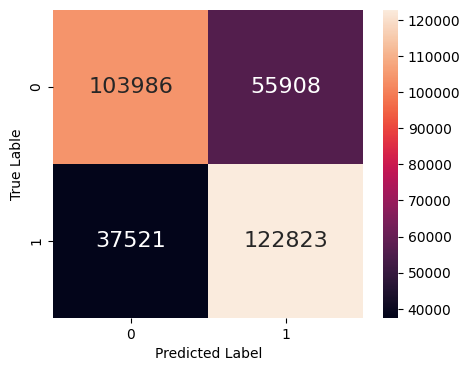

In [25]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(5,4))
# cm_df = pd.DataFrame(cm, index = ['Negative','Positive'], columns = ['Negative','Positive'])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={'size':16})
plt.xlabel("Predicted Label"); plt.ylabel('True Lable');

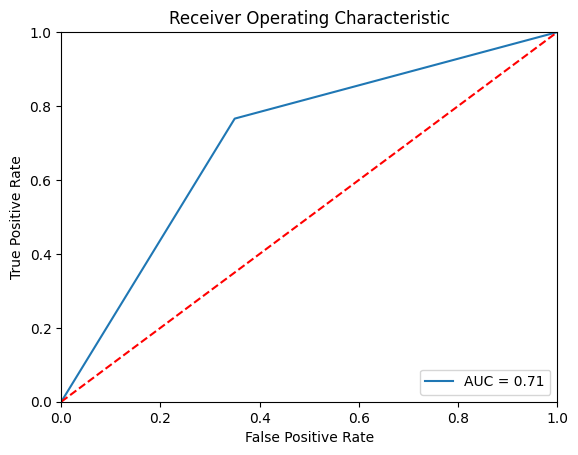

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()